In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn.preprocessing import StandardScaler
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Read the CSV file
listing_dfs = []
review_dfs = []

cities = ["nyc", "toronto", "mtl"]
for city in cities:
    listings_csv_files_path = f"./data/{city}_listings.csv"
    reviews_csv_files_path = f"./data/{city}_reviews.csv"

    listing_df = pd.read_csv(listings_csv_files_path)
    review_df = pd.read_csv(reviews_csv_files_path)

    listing_dfs.append(listing_df)
    review_dfs.append(review_df)

listing_data = pd.concat(listing_dfs, ignore_index=True)
review_data = pd.concat(review_dfs, ignore_index=True)

In [4]:
stop_words = set(stopwords.words('english'))

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [5]:
def remove_non_alphanumeric(text):
    if type(text) is str:
        return ''.join(char for char in text if char.isalnum() or char.isspace())

review_data['processed_comments'] = review_data['comments'].apply(lambda x: remove_non_alphanumeric(x))
review_data['processed_comments'] = review_data['processed_comments'].dropna()

In [6]:
# Function to tokenize a review and remove stop words
def tokenize_and_remove_stopwords(review):
    review = str(review)
    tokens = word_tokenize(review.lower())
    return [token for token in tokens if token.isalpha() and token not in stop_words]

review_data['tokens'] = review_data['processed_comments'].apply(tokenize_and_remove_stopwords)
review_data['sentiment'] = review_data['processed_comments'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
review_data.to_csv("./data/processed_reviews.csv")

In [7]:
average_sentiment_per_listing = review_data.groupby('listing_id')['sentiment'].mean().reset_index()
listing_data = pd.merge(listing_data, average_sentiment_per_listing, left_on='id', right_on='listing_id', how='left')

In [8]:
processed_df = listing_data.drop(columns=["id", "host_id", "host_url", "host_since", "host_name", "host_location", "host_about", "scrape_id", "last_scraped", "source", 
                                          "review_scores_accuracy", "review_scores_cleanliness", "review_scores_checkin", "review_scores_communication", "review_scores_location", 
                                          "review_scores_value", "number_of_reviews", "number_of_reviews_l30d", "reviews_per_month", "host_listings_count", "beds",
                                          "host_thumbnail_url", "host_picture_url", "listing_url", "scrape_id", "last_scraped", "source", "description", "name",
                                          "neighborhood_overview", "picture_url", "host_neighbourhood", "host_verifications", "neighbourhood", "neighbourhood_group_cleansed",
                                          "latitude", "longitude", "room_type", "bathrooms", "bedrooms", "amenities", "minimum_nights", "maximum_nights",
                                          "minimum_minimum_nights", "maximum_minimum_nights", "minimum_maximum_nights", "maximum_maximum_nights", "minimum_nights_avg_ntm",
                                          "maximum_nights_avg_ntm", "calendar_updated", "has_availability", "availability_30", "availability_60", "availability_90",
                                          "calendar_last_scraped", "first_review", "last_review", "license", "instant_bookable", "calculated_host_listings_count",
                                          "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms"])

# ordinal mapping - bathroom_text, host_response_time
# one-hot - property_type
# changing t/f to 1/0 - host_is_superhost, host_has_profile_pic, host_identity_verified "availability_60", "availability_365",
# correlation w price - neighbourhood

In [9]:
processed_df = processed_df[(processed_df['availability_365'] != 0) & (processed_df['availability_365'] != 365)]

In [10]:
property_type_counts = processed_df['property_type'].value_counts()
property_types_to_keep = property_type_counts[property_type_counts >= 20].index.tolist()
processed_df = processed_df[processed_df['property_type'].isin(property_types_to_keep)]    

In [11]:
def is_shared_bathroom(text):
    if pd.isnull(text):
        return None
    elif "shared" in text.lower():
        return 1
    else:
        return 0

bathroom_mapping = {float('nan'): float('nan'), '0 shared baths': 0,
                    'Shared half-bath': 0.5, 'Half-bath': 0.5, '1 shared bath': 1, '1 bath': 1, '1 private bath': 1,  
                    '1.5 shared baths': 1.5, '1.5 baths': 1.5,
                    '2 shared baths': 2, '2 baths': 2, '2.5 baths': 2.5,
                    '3 baths': 3, '3.5 baths': 3.5,  
                    '4 baths': 4, '4.5 baths': 4.5,
                    '4.5 shared baths': 4.5, '5 baths': 5,
                    '3 shared baths': 3, 'Private half-bath': 0.5, '0 baths': 0,
                    '8 baths': 8, '6 baths': 6, '2.5 shared baths': 2.5,
                    '3.5 shared baths': 3.5, '5.5 baths': 5.5, '6.5 baths': 6.5,
                    '4 shared baths': 4, '7 baths': 7}

processed_df['is_shared_bathroom'] = processed_df['bathrooms_text'].apply(is_shared_bathroom)
processed_df['bathrooms_ordinal'] = processed_df['bathrooms_text'].map(bathroom_mapping)
processed_df.drop(columns=['bathrooms_text'], inplace=True)

In [12]:
response_mapping = {'within an hour': 5, 'within a few hour': 4, 'within a day': 3, 'a few days or more': 2, float('nan'): 0}
processed_df['response_time_ordinal'] = processed_df['host_response_time'].map(response_mapping)
processed_df.drop(columns=['host_response_time'], inplace=True)

In [13]:
one_hot_encoded_df = pd.get_dummies(processed_df['property_type'])
processed_df = pd.concat([processed_df, one_hot_encoded_df], axis=1)
processed_df.drop(columns=['property_type'], inplace=True)

In [14]:
replace_cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified"]
processed_df[replace_cols] = processed_df[replace_cols].replace({'t': 1, 'f': -1})

In [15]:
cols_to_inject = ["host_response_rate", "host_acceptance_rate"]
for col in cols_to_inject:
    processed_df[col] = processed_df[col].str.rstrip('%').astype(float) / 100

temp_data = processed_df[cols_to_inject]
average_values = temp_data.dropna()[cols_to_inject].mean()
processed_df['host_response_rate'].fillna(average_values[0], inplace=True)
processed_df['host_acceptance_rate'].fillna(average_values[1], inplace=True)

In [16]:
processed_df['price'] = processed_df['price'].str.replace('$', '')
processed_df['price'] = processed_df['price'].str.replace(',', '').astype(float)

C:\Users\tommy\AppData\Local\Temp\ipykernel_26028\3095121920.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  processed_df['price'] = processed_df['price'].str.replace('$', '')


In [17]:
neighbourhood_data = processed_df[["neighbourhood_cleansed", "price"]]
one_hot_encoded_df = pd.get_dummies(neighbourhood_data['neighbourhood_cleansed'])
neighbourhood_data = pd.concat([neighbourhood_data, one_hot_encoded_df], axis=1)
neighbourhood_data = neighbourhood_data.drop(columns=["neighbourhood_cleansed"])
correlation = neighbourhood_data.corr()
correlation = correlation["price"][1:]

In [18]:
corr_dict = correlation.to_dict()
processed_df['neighbourhood_cleansed'] = processed_df['neighbourhood_cleansed'].map(corr_dict)

In [19]:
processed_df['review_scores_rating'] = np.log(processed_df['review_scores_rating'])

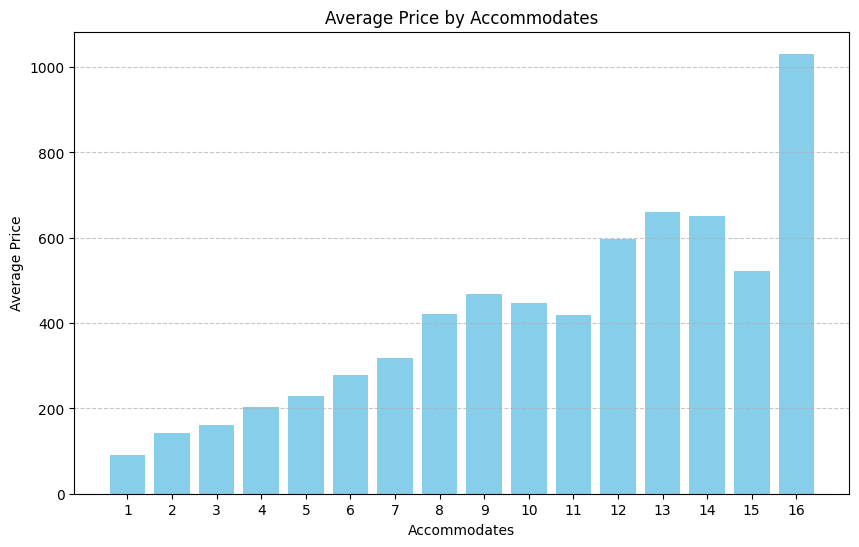

In [20]:
# Grouping the data by 'accommodates' and calculating the average price
average_price_by_accommodates = processed_df.groupby('accommodates')['price'].mean()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.bar(average_price_by_accommodates.index, average_price_by_accommodates.values, color='skyblue')
plt.xlabel('Accommodates')
plt.ylabel('Average Price')
plt.title('Average Price by Accommodates')
plt.xticks(average_price_by_accommodates.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

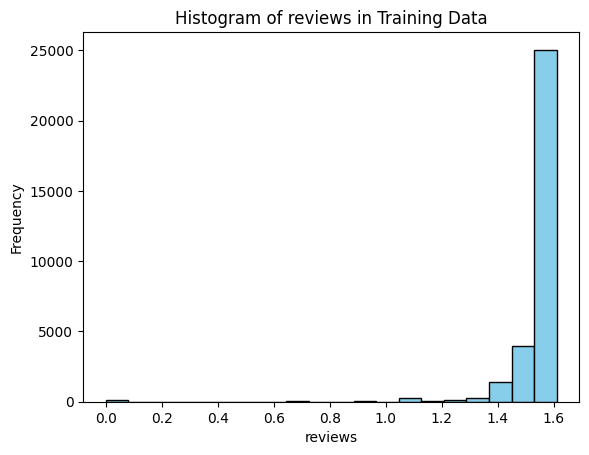

In [21]:
reviews = processed_df["review_scores_rating"]
plt.hist(reviews, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('reviews')
plt.ylabel('Frequency')
plt.title('Histogram of reviews in Training Data')
plt.show()

(40283, 51)


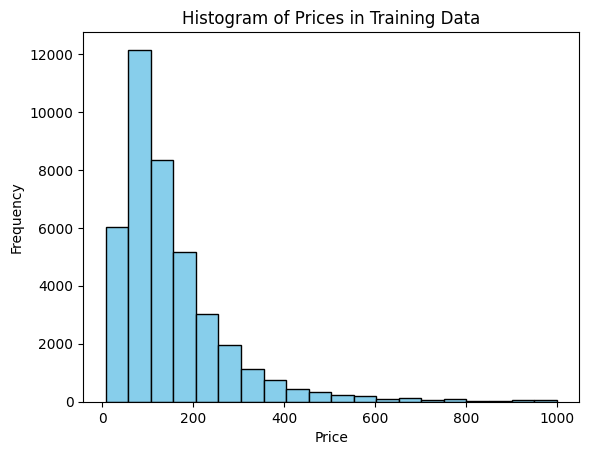

In [22]:
processed_df = processed_df[processed_df['accommodates'] < 12]
processed_df = processed_df[processed_df['price'] < 1000]
price_history = processed_df["price"]
print(processed_df.shape)
plt.hist(price_history, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices in Training Data')
plt.show()

In [23]:
processed_df.iloc[:, :20].describe(include='all')

,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,accommodates,price,availability_365,number_of_reviews_ltm,review_scores_rating,listing_id,sentiment,is_shared_bathroom,bathrooms_ordinal,response_time_ordinal,Entire bungalow,Entire condo,Entire guest suite
count,40283.000000,40283.000000,39923.000000,40282.000000,40282.000000,40282.000000,40283.000000,40283.000000,40283.000000,40283.000000,40283.000000,29749.000000,2.953000e+04,29530.000000,40266.000000,40263.000000,33530.000000,40283.000000,40283.000000,40283.000000
mean,0.947503,0.837136,-0.301305,159.357132,0.939874,0.863115,0.001820,2.990691,153.985627,200.704118,8.080654,1.549217,3.856663e+17,0.688181,0.200765,1.203735,3.644975,0.004046,0.095698,0.019959
std,0.151067,0.237964,0.953540,781.965436,0.341526,0.505014,0.012421,1.790416,124.954517,111.054063,15.436519,0.137434,4.204464e+17,0.230481,0.400578,0.502447,2.053083,0.063483,0.294180,0.139860
min,0.000000,0.000000,-1.000000,1.000000,-1.000000,-1.000000,-0.015674,1.000000,8.000000,1.000000,0.000000,0.000000,2.595000e+03,-0.988200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.948970,0.800000,-1.000000,2.000000,1.000000,1.000000,-0.006712,2.000000,75.000000,90.000000,0.000000,1.541159,3.043553e+07,0.606123,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000
50%,1.000000,0.940000,-1.000000,4.000000,1.000000,1.000000,-0.002295,2.000000,119.000000,191.000000,2.000000,1.581038,5.321544e+07,0.733834,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,15.000000,1.000000,1.000000,0.008746,4.000000,194.000000,300.000000,9.000000,1.609438,8.130590e+17,0.833650,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,8912.000000,1.000000,1.000000,0.079953,11.000000,999.000000,364.000000,831.000000,1.609438,1.101569e+18,0.998300,1.000000,8.000000,5.000000,1.000000,1.000000,1.000000


In [24]:
processed_df = processed_df.dropna() 
processed_df.to_csv("./data/processed_listings.csv")

In [25]:
scaler = MinMaxScaler()
processed_df_normalized = processed_df.copy()
processed_df_normalized[processed_df.columns] = scaler.fit_transform(processed_df_normalized)

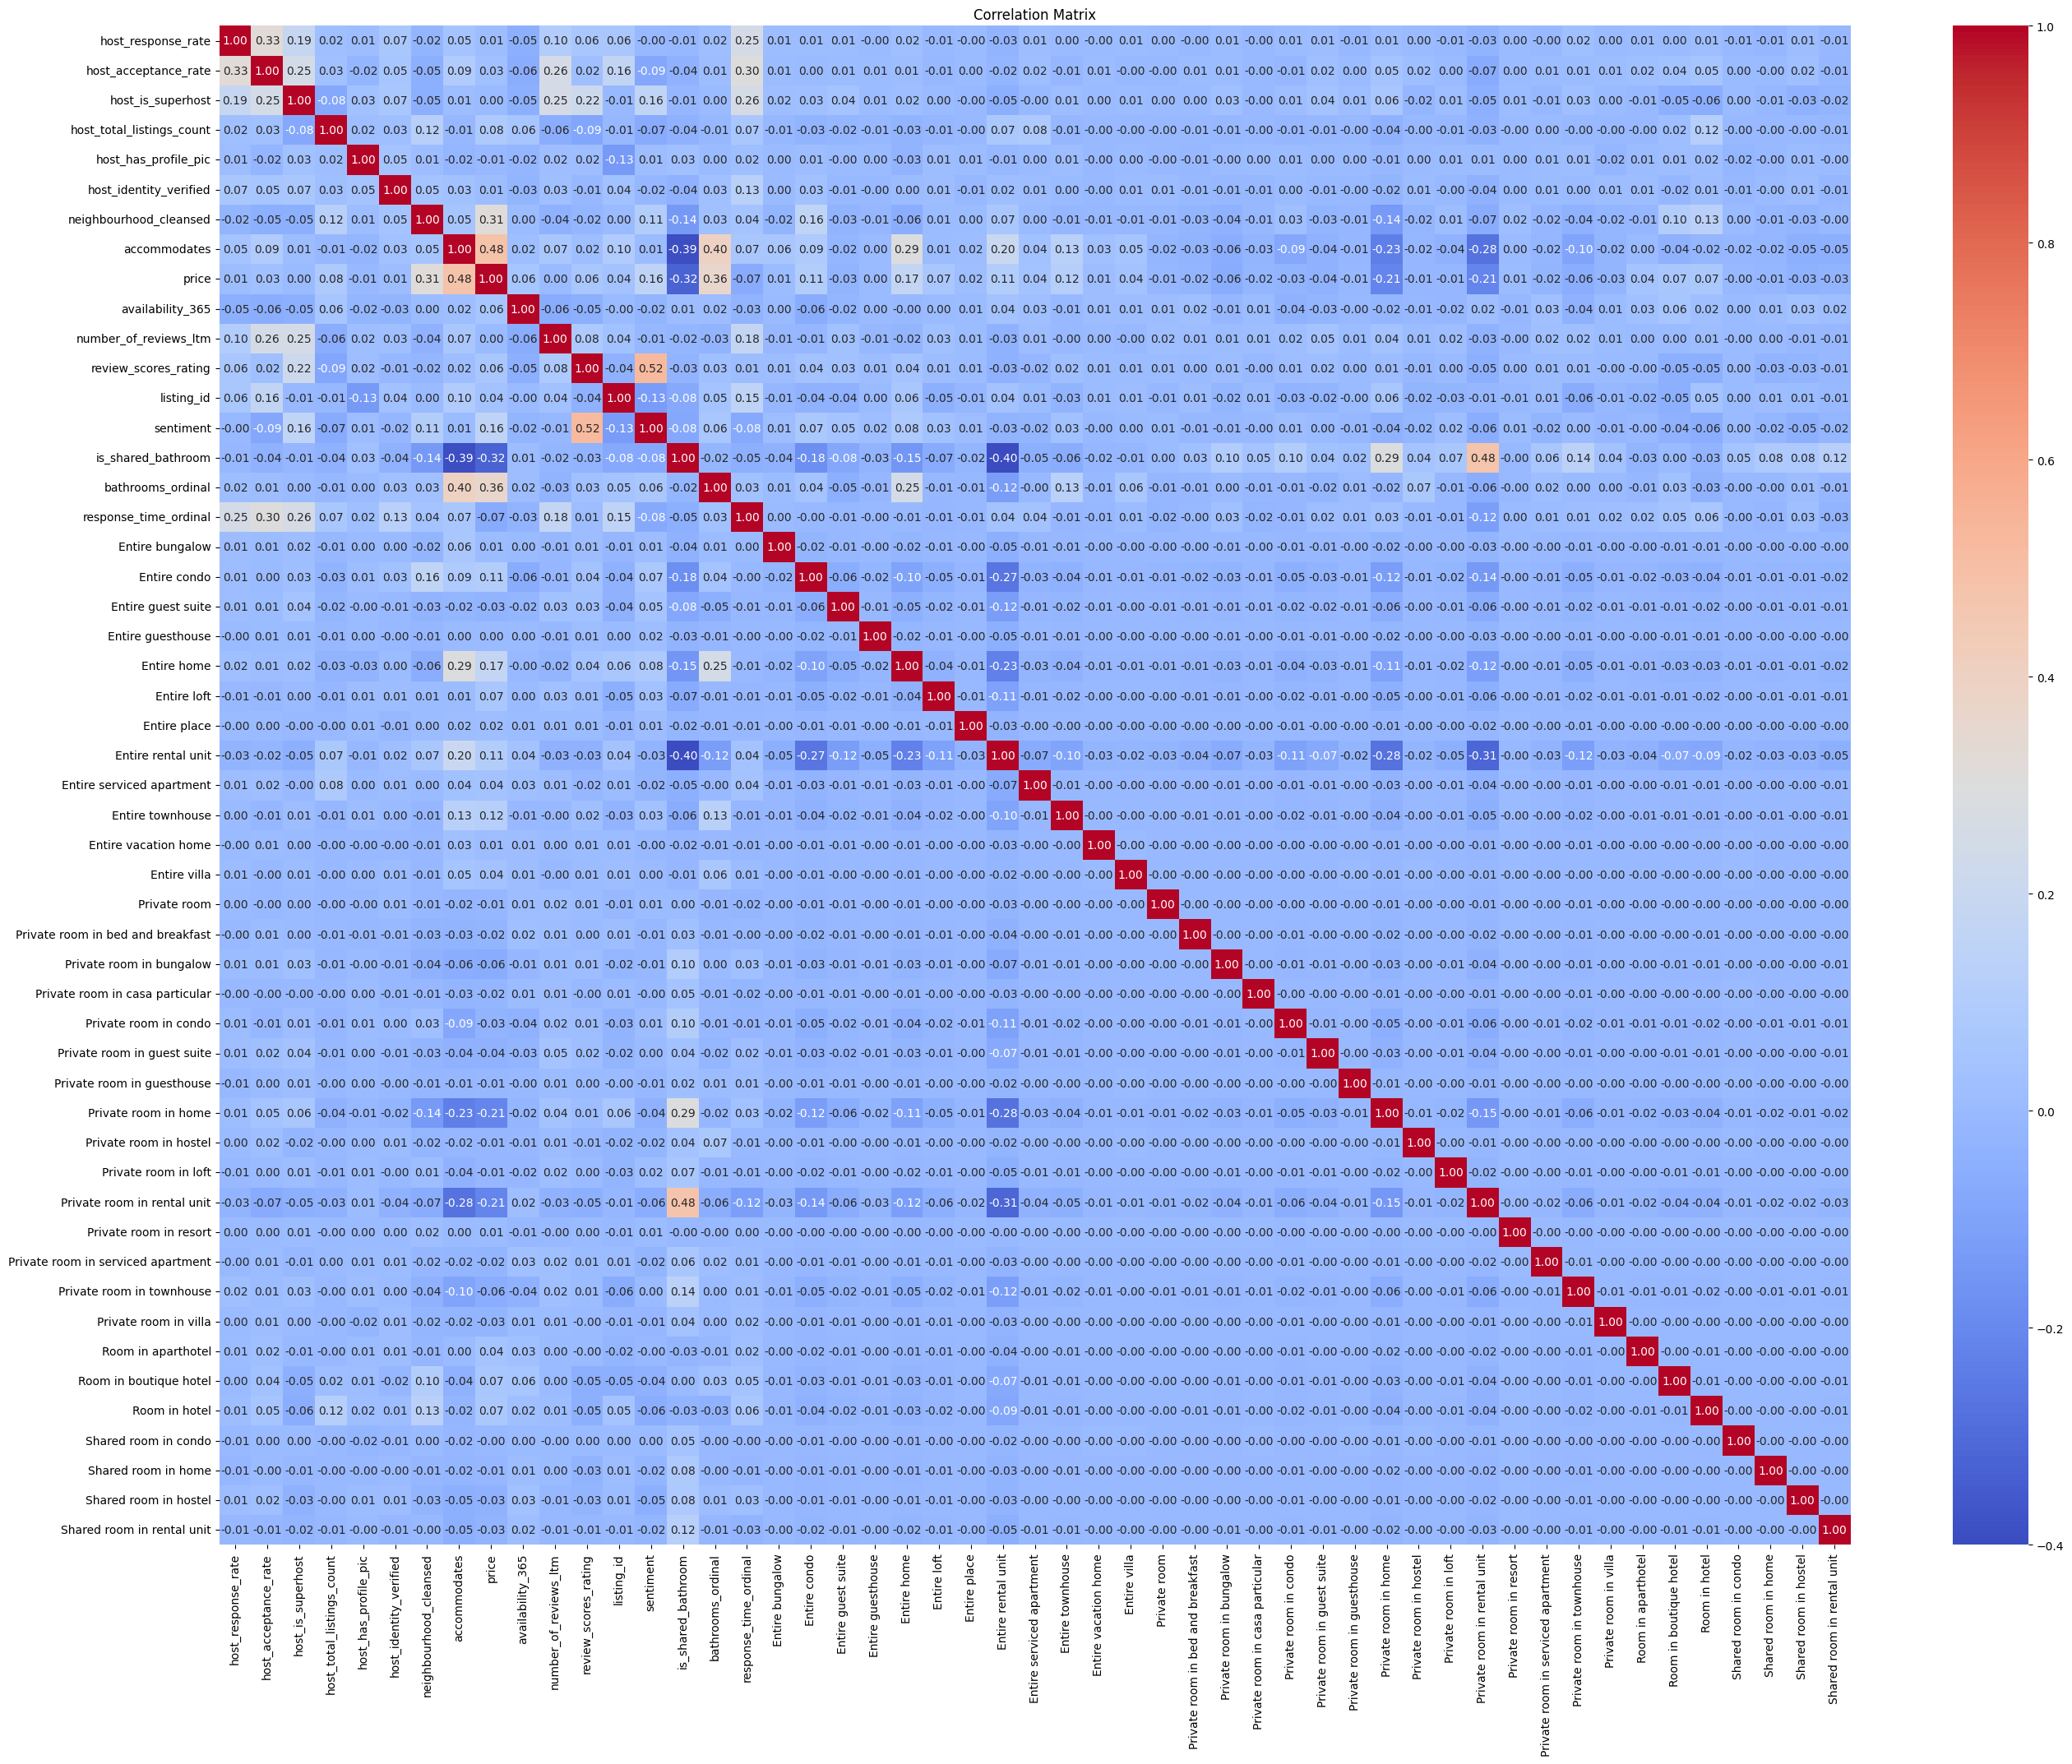

In [26]:
correlation = processed_df_normalized.corr()

# Plot heatmap
plt.figure(figsize=(32, 24))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
X = processed_df_normalized.drop(columns=['price']) 
y = processed_df_normalized['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and testing sets

model = DecisionTreeRegressor(random_state=69)  

model.fit(X_train, y_train)  # Train the model on the training data

y_pred = model.predict(X_test)  # Make predictions on the testing data
mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
print("Mean Squared Error:", mse)

Mean Squared Error: 0.015195605872982245


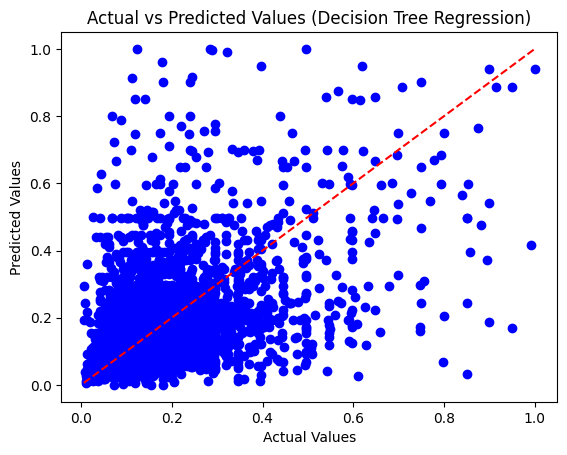

In [28]:
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (Decision Tree Regression)')
plt.show()

In [29]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),  # Batch normalization layer
    Dense(128, activation='relu'),  # Additional dense ReLU layer
    BatchNormalization(),  # Batch normalization layer
    Dense(128, activation='relu'),  # Additional dense ReLU layer
    BatchNormalization(),  # Batch normalization layer
    Dense(64, activation='relu'),  # Additional dense ReLU layer
    BatchNormalization(),  # Batch normalization layer
    Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train Model
history = model.fit(X_train, y_train, epochs=40, batch_size=128, validation_split=0.2)  # Train the model on the training data

# Step 5: Evaluate Model
mse = model.evaluate(X_test, y_test)  # Evaluate the model on the testing data
print("Mean Squared Error:", mse)

Epoch 1/40
121/121 [==============================] - 2s 3ms/step - loss: 0.1675 - val_loss: 0.0533
Epoch 2/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0288
Epoch 3/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0210
Epoch 4/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0191 - val_loss: 0.0148
Epoch 5/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0159 - val_loss: 0.0128
Epoch 6/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0114
Epoch 7/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0113
Epoch 8/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0120 - val_loss: 0.0102
Epoch 9/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 10/40
121/121 [==============================] - 0s 2ms/step - loss: 0.0109 - val_loss: 0.0104

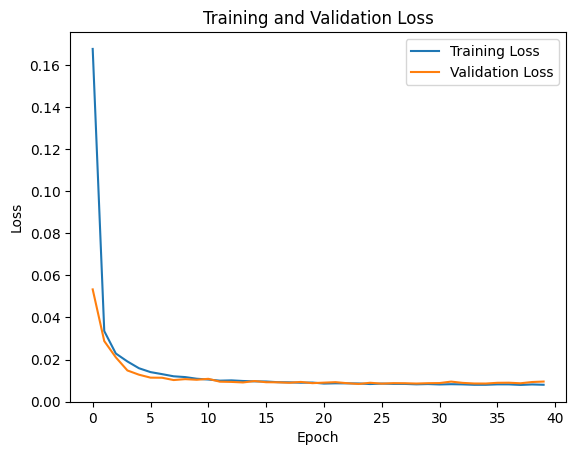

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()